# Model Exploration

## Imports <a name="imports"></a>

In [97]:
#Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV

#Regression Metrics
from sklearn.metrics import mean_squared_error

#Classification Models
from sklearn.cluster import KMeans
from scipy.stats import norm
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

#XGBoost
import xgboost as xgb

#Classification Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from yellowbrick.classifier import ClassPredictionError
from yellowbrick.regressor import PredictionError
from yellowbrick.features import Rank1D
from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz

import datetime

## Import Data <a name="importData"></a>

### Crowdedness Data <a name="CrowdData"></a>

In [2]:
#Full Crowdedness Dataset
crowd_df = pd.read_csv("../../../Data_thesis/Full_Datasets/Crowdedness.csv")

In [3]:
#Convert DF to Dict
crowd_dict = crowd_df.to_dict("index")

#Transform date from string to datetime object
for k, v in crowd_dict.items():
    v["Date"] = pd.Timestamp.strptime(v["Date"], "%Y-%m-%d")
    
#Convert back to dict
crowd_df = pd.DataFrame.from_dict(crowd_dict, orient="index")

In [4]:
crowd_df = crowd_df.sort_values(by=["Date"]).reset_index().drop(columns=["index"])

In [5]:
# Start data
start_date = crowd_df.min().Date

# End date
end_date = crowd_df.max().Date

In [6]:
crowd_df.head()

,Sensor,Date,Hour,SensorLongitude,SensorLatitude,CrowdednessCount
0,GAWW-02,2018-03-11,0,4.898903,52.373786,0
1,GAWW-02,2018-03-11,2300,4.898903,52.373786,0
2,GAWW-02,2018-03-11,2200,4.898903,52.373786,0
3,GAWW-02,2018-03-11,2100,4.898903,52.373786,0
4,GAWW-02,2018-03-11,2000,4.898903,52.373786,0


### Amsterdam Event Data <a name="EventData"></a>
Import Amsterdam Event Data

In [7]:
#Full Events Dataset
events_df = pd.read_csv("../../../Data_thesis/Full_Datasets/Events.csv")

In [8]:
#Convert DF to Dict
events_dict = events_df.to_dict("index")

#Transform date from string to datetime object
for k, v in events_dict.items():
    v["Date"] = pd.Timestamp.strptime(v["Date"], "%Y-%m-%d")
    
#Convert back to dict
events_df = pd.DataFrame.from_dict(events_dict, orient="index")

In [9]:
events_df = events_df[(events_df["Date"] > start_date) & (events_df["Date"] < end_date)].reset_index().drop(columns=["index"])

In [10]:
events_df.head()

,Date,Event,Latitude,Longtitude
0,2018-04-20,Springsnow Festival,52.372638,4.894106
1,2018-05-20,Springsnow Festival,52.372638,4.894106
2,2018-06-02,Holland Festival,52.361582,4.885479
3,2018-06-03,Holland Festival,52.361582,4.885479
4,2018-06-04,Holland Festival,52.361582,4.885479


### GVB Data <a name="GVBData"></a>
Import the GVB data and convert the Date column to [Pandas Timestamp](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html). Aftwerwards the dataset is split into the following two sets:
- Training: All data before the given *series_date*
    - Used for training and validating the model
- Series: All data before the given *series_date*
    - Used to construct a Time Series

In [11]:
#Full GVB Dataset
gvb_df = pd.read_csv("../../../Data_thesis/Full_Datasets/GVB.csv")

In [12]:
#Convert DF to Dict
gvb_dict = gvb_df.to_dict("index")

#Transform date from string to datetime object
for k, v in gvb_dict.items():
    v["Date"] = pd.Timestamp.strptime(v["Date"], "%Y-%m-%d")
    
#Convert back to dict
gvb_df = pd.DataFrame.from_dict(gvb_dict, orient="index")

In [13]:
gvb_df = gvb_df[(gvb_df["Date"] > start_date) & (gvb_df["Date"] < end_date)].reset_index().drop(columns=["index"])

In [14]:
#Contents
gvb_df.head()

,Date,Hour,NieuwmarktCode,NieuwmarktLat,NieuwmarktLon,NieuwmarktArrivals,NieuwmarktDepartures,NieuwezijdsCode,NieuwezijdsLat,NieuwezijdsLon,...,DamLon,DamArrivals,DamDepartures,SpuiCode,SpuiLat,SpuiLon,SpuiArrivals,SpuiDepartures,weekday,is_weekend
0,2018-04-01,0,NMT,52.371942,4.901239,31.0,115.0,5069,52.376288,4.893731,...,4.89008,43.0,254.0,5062,52.369097,4.889259,0.0,46.0,6,1
1,2018-04-01,600,NMT,52.371942,4.901239,67.0,50.0,5069,52.376288,4.893731,...,4.89008,129.0,0.0,5062,52.369097,4.889259,11.0,0.0,6,1
2,2018-04-01,700,NMT,52.371942,4.901239,99.0,120.0,5069,52.376288,4.893731,...,4.89008,174.0,57.0,5062,52.369097,4.889259,54.0,17.0,6,1
3,2018-04-01,800,NMT,52.371942,4.901239,222.0,236.0,5069,52.376288,4.893731,...,4.89008,491.0,111.0,5062,52.369097,4.889259,139.0,64.0,6,1
4,2018-04-01,900,NMT,52.371942,4.901239,269.0,169.0,5069,52.376288,4.893731,...,4.89008,764.0,151.0,5062,52.369097,4.889259,215.0,61.0,6,1


## Data Preperation <a name="DataPrep"></a>

### Combine datasets <a name="CombData"></a>

In [15]:
gvb_crowd_df = pd.merge(gvb_df, crowd_df, on=["Date", "Hour"], how="outer")

In [16]:
gvb_crowd_df.head()

,Date,Hour,NieuwmarktCode,NieuwmarktLat,NieuwmarktLon,NieuwmarktArrivals,NieuwmarktDepartures,NieuwezijdsCode,NieuwezijdsLat,NieuwezijdsLon,...,SpuiLat,SpuiLon,SpuiArrivals,SpuiDepartures,weekday,is_weekend,Sensor,SensorLongitude,SensorLatitude,CrowdednessCount
0,2018-04-01,0,NMT,52.371942,4.901239,31.0,115.0,5069.0,52.376288,4.893731,...,52.369097,4.889259,0.0,46.0,6.0,1.0,GAWW-02,4.898903,52.373786,3813
1,2018-04-01,600,NMT,52.371942,4.901239,67.0,50.0,5069.0,52.376288,4.893731,...,52.369097,4.889259,11.0,0.0,6.0,1.0,GAWW-02,4.898903,52.373786,105
2,2018-04-01,700,NMT,52.371942,4.901239,99.0,120.0,5069.0,52.376288,4.893731,...,52.369097,4.889259,54.0,17.0,6.0,1.0,GAWW-02,4.898903,52.373786,72
3,2018-04-01,800,NMT,52.371942,4.901239,222.0,236.0,5069.0,52.376288,4.893731,...,52.369097,4.889259,139.0,64.0,6.0,1.0,GAWW-02,4.898903,52.373786,71
4,2018-04-01,900,NMT,52.371942,4.901239,269.0,169.0,5069.0,52.376288,4.893731,...,52.369097,4.889259,215.0,61.0,6.0,1.0,GAWW-02,4.898903,52.373786,187


In [17]:
full = pd.merge(gvb_crowd_df, events_df, on=["Date"], how="outer")
full = full.rename(index=str, columns={"Latitude": "event_lat", "Longtitude": "event_lon", "Event": "is_event"})
full = full.fillna(0.0)

In [18]:
full_dict = full.to_dict("index")

for k, v in full_dict.items():
    if v["is_event"] != 0.0:
        v["is_event"] = 1.0
    
    if v["Hour"] == 0:
        v["Hour"] = 2400

full = pd.DataFrame.from_dict(full_dict, orient="index").reset_index().drop(columns=["index"])

### Make Time circular

In [19]:
full = full.assign(Year=0, month_sin=0, month_cos=0, day_sin=0, day_cos=0, hour_sin=0, hour_cos=0)

In [20]:
full.head()

,Date,Hour,NieuwmarktCode,NieuwmarktLat,NieuwmarktLon,NieuwmarktArrivals,NieuwmarktDepartures,NieuwezijdsCode,NieuwezijdsLat,NieuwezijdsLon,...,is_event,event_lat,event_lon,Year,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,2018-04-01,2400,NMT,52.371942,4.901239,31.0,115.0,5069.0,52.376288,4.893731,...,0.0,0.000000,0.000000,0,0,0,0,0,0,0
1,2018-04-01,600,NMT,52.371942,4.901239,67.0,50.0,5069.0,52.376288,4.893731,...,0.0,0.000000,0.000000,0,0,0,0,0,0,0
2,2018-04-01,1500,NMT,52.371942,4.901239,362.0,407.0,5069.0,52.376288,4.893731,...,0.0,0.000000,0.000000,0,0,0,0,0,0,0
3,2018-07-01,700,NMT,52.371942,4.901239,54.0,25.0,5069.0,52.376288,4.893731,...,0.0,0.000000,0.000000,0,0,0,0,0,0,0
4,2018-06-03,1800,NMT,52.371942,4.901239,487.0,400.0,5069.0,52.376288,4.893731,...,1.0,52.372638,4.894106,0,0,0,0,0,0,0


In [21]:
time_dict = full.to_dict("index")

for k, v in time_dict.items():    
    v["Year"] = v["Date"].year
    
    v["month_sin"] = np.sin(2 * np.pi * v["Date"].month / 12)
    v["month_cos"] = np.cos(2 * np.pi * v["Date"].month / 12)
    
    v["day_sin"] = np.sin(2 * np.pi * v["Date"].day / 365)
    v["day_cos"] = np.cos(2 * np.pi * v["Date"].day / 365)

    v["hour_sin"] = np.sin(2 * np.pi * v["Hour"] / 2400)
    v["hour_cos"] = np.cos(2 * np.pi * v["Hour"] / 2400)
    
full = pd.DataFrame.from_dict(time_dict, orient="index").reset_index()

In [22]:
cols = ["Date", "Hour",'is_event', 'event_lat', 'event_lon', 'NieuwmarktLat', 'NieuwmarktLon', 
        'NieuwmarktArrivals', 'NieuwmarktDepartures', 'NieuwezijdsLat', 'NieuwezijdsLon', 
        'NieuwezijdsArrivals', 'NieuwezijdsDepartures', 'DamLat', 'DamLon', 'DamArrivals', 
        'DamDepartures', 'SpuiLat', 'SpuiLon', 'SpuiArrivals', 'SpuiDepartures', 'weekday', 'is_weekend',
        'SensorLongitude', 'SensorLatitude', 'Year', 'month_sin', 'month_cos', 
        'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'CrowdednessCount']

full = full[cols]

In [23]:
full.head()

,Date,Hour,is_event,event_lat,event_lon,NieuwmarktLat,NieuwmarktLon,NieuwmarktArrivals,NieuwmarktDepartures,NieuwezijdsLat,...,SensorLongitude,SensorLatitude,Year,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,CrowdednessCount
0,2018-04-01,2400,0.0,0.000000,0.000000,52.371942,4.901239,31.0,115.0,52.376288,...,4.898903,52.373786,2018,8.660254e-01,-0.500000,0.017213,0.999852,-2.449294e-16,1.000000e+00,3813
1,2018-04-01,600,0.0,0.000000,0.000000,52.371942,4.901239,67.0,50.0,52.376288,...,4.898903,52.373786,2018,8.660254e-01,-0.500000,0.017213,0.999852,1.000000e+00,6.123234e-17,105
2,2018-04-01,1500,0.0,0.000000,0.000000,52.371942,4.901239,362.0,407.0,52.376288,...,4.898903,52.373786,2018,8.660254e-01,-0.500000,0.017213,0.999852,-7.071068e-01,-7.071068e-01,3669
3,2018-07-01,700,0.0,0.000000,0.000000,52.371942,4.901239,54.0,25.0,52.376288,...,0.000000,0.000000,2018,-5.000000e-01,-0.866025,0.017213,0.999852,9.659258e-01,-2.588190e-01,80
4,2018-06-03,1800,1.0,52.372638,4.894106,52.371942,4.901239,487.0,400.0,52.376288,...,4.898903,52.373786,2018,1.224647e-16,-1.000000,0.051620,0.998667,-1.000000e+00,-1.836970e-16,3470


### Visualization

In [24]:
x = full.drop(["CrowdednessCount", "Date", "Hour"], axis=1)
y = full["CrowdednessCount"]

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\yellowbrick\features\rankd.py:262: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = X.as_matrix()
D:\Programs\Anaconda\envs\Analytics\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


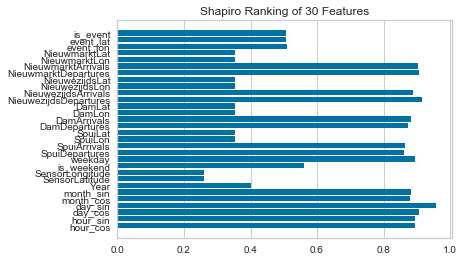

In [25]:
#Rank features - 1D
visualizer = Rank1D(algorithm='shapiro')

visualizer.fit(x, y)                # Fit the data to the visualizer
visualizer.transform(x)             # Transform the data
visualizer.poof() 

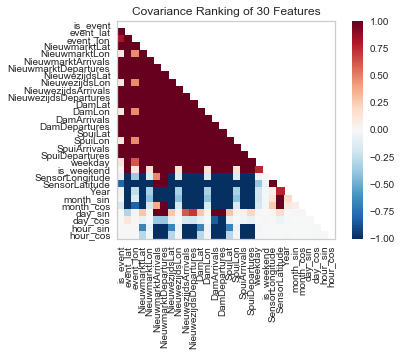

In [26]:
visualizer = Rank2D(algorithm='covariance')
visualizer.fit(x, y)                # Fit the data to the visualizer
visualizer.transform(x)             # Transform the data
visualizer.poof() 

### Split Data into Training/Test and Time Series data

In [27]:
split_date = pd.Timestamp(2018, 12, 31)

TrainTest_df = full[full["Date"] <= split_date].reset_index().drop(columns=["index"])
TimeSeries_df = full[full["Date"] > split_date].reset_index().drop(columns=["index"])

### Criteria for train and test Model <a name="testModel"></a>
Based on the dates.

In [28]:
all_dates = TrainTest_df["Date"].values
np.random.shuffle(all_dates)

In [29]:
split_dates = int(all_dates.size * 0.9)
train_set_dates = all_dates[:split_dates]
test_set_dates = all_dates[split_dates:]

## Regression Models <a name="regModels"></a>

### Train, Test, Evaluation Split

In [30]:
train_df_reg = TrainTest_df[TrainTest_df["Date"].isin(train_set_dates)].drop(columns=["Date", "Hour"])

test_df_reg = TrainTest_df[TrainTest_df["Date"].isin(test_set_dates)].reset_index()

In [164]:
#Train
x_train_reg = train_df_reg.drop(["CrowdednessCount", "month_sin", "month_cos", "Year", "day_sin", "day_cos"], axis=1)
y_train_reg = train_df_reg["CrowdednessCount"]

#Test
x_test_reg = test_df_reg.drop(["CrowdednessCount", "Date", "Hour", "index", "month_sin", "month_cos", 
                               "Year", "day_sin", "day_cos"], axis=1)
y_test_reg = test_df_reg["CrowdednessCount"]

test_reg_series = test_df_reg[(test_df_reg["Date"] == test_set_dates[2]) & (test_df_reg["SensorLongitude"] == 4.8989027)
                             ].reset_index()
x_test_reg_series = test_reg_series.drop(["CrowdednessCount", "Date", "Hour", "level_0", "index", "month_sin", 
                                          "month_cos", "Year", "day_sin", "day_cos"], axis=1)
y_test_reg_series = test_reg_series["CrowdednessCount"]

#Select data Series set
seriesDate = TimeSeries_df["Date"].values

x_eval_reg = TimeSeries_df.drop(["CrowdednessCount", "Date", "Hour", "month_sin", "month_cos", "Year", 
                                 "day_sin", "day_cos"], axis=1)
y_eval_reg = TimeSeries_df["CrowdednessCount"]

#Subset timeseries
sub_series = TimeSeries_df[(TimeSeries_df["SensorLongitude"] == 4.8989027) & (TimeSeries_df["Date"] == seriesDate[1])
                          ].reset_index()

#Time series
x_series_reg = sub_series.drop(["Date", "Hour","CrowdednessCount", "index", "month_sin", "month_cos", "Year", 
                                "day_sin", "day_cos"], axis=1)
y_series_reg = sub_series["CrowdednessCount"]


feature_labels_reg = train_df_reg.columns.values

### Linear Regression <a name="regBaseModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

#### Training

In [165]:
#Give parameters model
reg_base = LinearRegression()

In [166]:
#Fit the model
reg_base.fit(x_train_reg, y_train_reg)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

#### Test

In [167]:
reg_base_score = reg_base.score(x_test_reg, y_test_reg)

y_pred_reg_base = reg_base.predict(x_test_reg)
base_reg_mse = mean_squared_error(y_pred_reg_base, y_test_reg)

print("R^2 Score: ", reg_base_score)
print("MSE: ", base_reg_mse)
print("RMSE: ", np.sqrt(base_reg_mse))

R^2 Score:  0.6669579434478063
MSE:  584105.476450373
RMSE:  764.2679349877063


In [168]:
for i in range(10):
    print("Predicted: ", y_pred_lr[i], "Real: ", y_test_reg[i])

Predicted:  2573.7419302876474 Real:  3813
Predicted:  842.5384090344846 Real:  105
Predicted:  3730.742891579983 Real:  3669
Predicted:  70.00211106341976 Real:  80
Predicted:  3489.963395221946 Real:  3470
Predicted:  2039.1954248468148 Real:  515
Predicted:  2149.939077639025 Real:  2315
Predicted:  2039.1954248468148 Real:  340
Predicted:  2382.7541839354067 Real:  3406
Predicted:  1661.257132707423 Real:  348


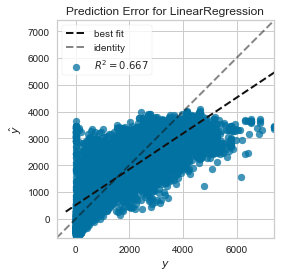

In [169]:
visualizer = PredictionError(reg_base)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_test_reg, y_test_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

In [170]:
#Time series
time_pred_reg_lr = reg_base.predict(x_test_reg_series)

time_pred_series_reg_lr = pd.Series(time_pred_reg_lr)
time_real_series_reg_lr = pd.Series(y_test_reg_series)

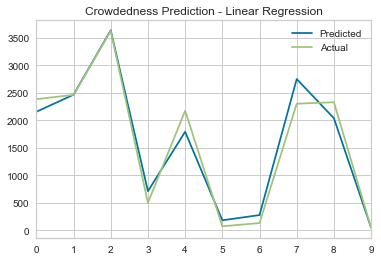

In [171]:
time_pred_series_reg_lr.plot(legend=True, title='Crowdedness Prediction - Linear Regression', label="Predicted")
time_real_series_reg_lr.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [172]:
base_score = reg_base.score(x_eval_reg, y_eval_reg)

y_pred_base = reg_base.predict(x_eval_reg)
base_mse = mean_squared_error(y_pred_base, y_eval_reg)

print("R^2 Score: ", base_score)
print("MSE: ", base_mse)
print("RMSE: ", np.sqrt(base_mse))

R^2 Score:  0.42610179006098087
MSE:  474492.7948214673
RMSE:  688.8343740126993


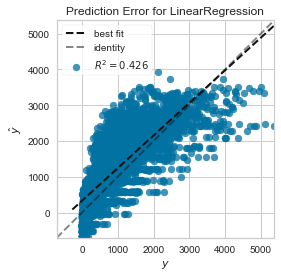

In [173]:
visualizer = PredictionError(reg_base)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_eval_reg, y_eval_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

In [174]:
#Time series
time_pred_lr = reg_base.predict(x_series_reg)

time_pred_series_lr = pd.Series(time_pred_lr)
time_real_series_lr = pd.Series(y_series_reg)

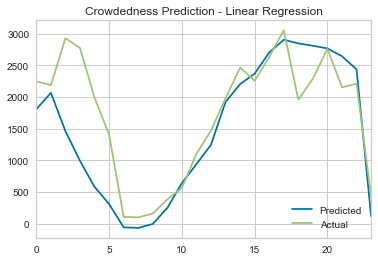

In [175]:
time_pred_series_lr.plot(legend=True, title='Crowdedness Prediction - Linear Regression', label="Predicted")
time_real_series_lr.plot(legend=True, label="Actual")
plt.show()

### Random Forrest Regressor <a name="regRFGModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

Parameters
- *N-Estimators*: Number of trees in the model
- *criterion*: loss function
- *n_jobs*: The number of jobs to run in parallel for both fit and predict
- *random_state*: random_state is the seed used by the random number generator
- *bootstrap*: Whether bootstrap samples are used when building trees

#### Training

In [176]:
#Set parameters model
reg_rfg = RandomForestRegressor(n_estimators=500, criterion="mse", n_jobs=100, random_state=42, bootstrap=True, 
                               oob_score=True)

In [177]:
#fit the model
reg_rfg.fit(x_train_reg, y_train_reg)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=100,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

#### Test

In [178]:
#Score the model
reg_rfg_score = reg_rfg.score(x_test_reg, y_test_reg)

#Test
y_pred_reg_rfg = reg_rfg.predict(x_test_reg)
reg_rfg_mse = mean_squared_error(y_pred_reg_rfg, y_test_reg)

print("R^2 Score: ", reg_rfg_score)
print("MSE Test: ", reg_rfg_mse)
print("RMSE Test: ", np.sqrt(reg_rfg_mse))

R^2 Score:  0.9706754338733101
MSE Test:  51430.86085419483
RMSE Test:  226.7837314583981


In [179]:
for i in range(10):
    print("Predicted: ", y_pred_reg_rfg[i], "Real: ", y_test_reg[i])

Predicted:  3502.458 Real:  3813
Predicted:  100.424 Real:  105
Predicted:  3182.75 Real:  3669
Predicted:  64.21666666666667 Real:  80
Predicted:  3404.674 Real:  3470
Predicted:  427.6430166666668 Real:  515
Predicted:  2247.862 Real:  2315
Predicted:  427.6430166666668 Real:  340
Predicted:  3315.18 Real:  3406
Predicted:  358.32581428571433 Real:  348


In [180]:
#Feature importance
importance = reg_rfg.feature_importances_
feature_indexes_by_importance = importance.argsort()
feature_indexes_by_importance = feature_indexes_by_importance[-5:]
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels_reg[index], (importance[index] *100.0)))

SensorLongitude-4.94%
SensorLatitude-4.99%
weekday-5.94%
month_sin-8.64%
Year-55.20%


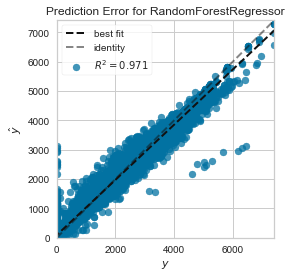

In [181]:
visualizer = PredictionError(reg_rfg)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_test_reg, y_test_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

In [182]:
#Time series
time_pred_reg_rfg = reg_rfg.predict(x_test_reg_series)

time_pred_series_reg_rfg = pd.Series(time_pred_reg_rfg)
time_real_series_reg_rfg = pd.Series(y_test_reg_series)

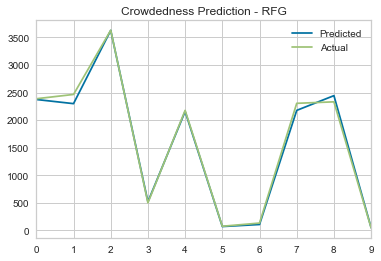

In [183]:
time_pred_series_reg_rfg.plot(legend=True, title='Crowdedness Prediction - RFG', label="Predicted")
time_real_series_reg_rfg.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [184]:
#Score the model
rfg_score = reg_rfg.score(x_eval_reg, y_eval_reg)

#Test
y_pred_rfg = reg_rfg.predict(x_eval_reg)
rfg_mse = mean_squared_error(y_pred_rfg, y_eval_reg)

print("R^2 Score: ", rfg_score)
print("MSE Test: ", rfg_mse)
print("RMSE Test: ", np.sqrt(rfg_mse))

R^2 Score:  0.49838245282978344
MSE Test:  414731.9294018637
RMSE Test:  643.9968395899655


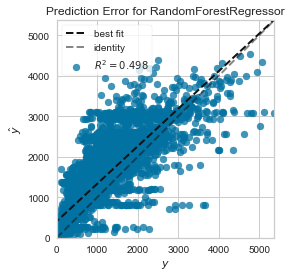

In [185]:
visualizer = PredictionError(reg_rfg)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_eval_reg, y_eval_reg)  # Evaluate the model on the test data
g = visualizer.poof()

In [186]:
#Time series
time_pred_rfg = reg_rfg.predict(x_series_reg)

time_pred_series_rfg = pd.Series(time_pred_rfg)
time_real_series_rfg = pd.Series(y_series_reg)

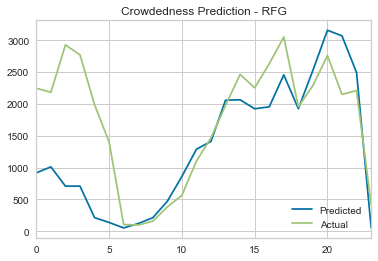

In [187]:
time_pred_series_rfg.plot(legend=True, title='Crowdedness Prediction - RFG', label="Predicted")
time_real_series_rfg.plot(legend=True, label="Actual")
plt.show()

### XGBoost Regressor
Through [SciKit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html) 

#### Training

In [188]:
xgb_reg = xgb.XGBRegressor(max_depth=6, learning_rate=0.05, n_estimators=300, verbosity=1,
                          booster="gbtree", n_jobs=20, random_state=42)

In [189]:
xgb_reg.fit(x_train_reg, y_train_reg)

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=300, n_jobs=20,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, verbosity=1)

#### Test

In [199]:
reg_xgb_score = xgb_reg.score(x_test_reg, y_test_reg)

#Training
y_pred_reg_xgb = xgb_reg.predict(x_test_reg)
reg_xgb_mse = mean_squared_error(y_pred_reg_xgb, y_test_reg)

print("R^2 Score: ", reg_xgb_score)
print("MSE Test: ", reg_xgb_mse)
print("RMSE Test: ", np.sqrt(reg_xgb_mse))

R^2 Score:  0.9233639941074634
MSE Test:  134407.98197839153
RMSE Test:  366.6169417503664


In [191]:
for i in range(10):
    print("Predicted: ", y_pred_xgb[i], "Real: ", y_test_reg[i])

Predicted:  3434.56 Real:  3813
Predicted:  93.01222 Real:  105
Predicted:  3620.6072 Real:  3669
Predicted:  49.659245 Real:  80
Predicted:  3460.6465 Real:  3470
Predicted:  513.0387 Real:  515
Predicted:  2172.3313 Real:  2315
Predicted:  513.0387 Real:  340
Predicted:  3506.5027 Real:  3406
Predicted:  280.4238 Real:  348


In [192]:
#Feature importance
importance = xgb_reg.feature_importances_
feature_indexes_by_importance = importance.argsort()
feature_indexes_by_importance = feature_indexes_by_importance[-5:]
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels_reg[index], (importance[index] *100.0)))

event_lon-3.38%
weekday-6.10%
SensorLongitude-6.47%
month_sin-9.72%
Year-64.94%


D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


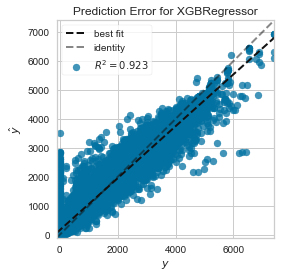

In [193]:
visualizer = PredictionError(xgb_reg)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_test_reg, y_test_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

In [194]:
#Time series
time_pred_reg_xgb = xgb_reg.predict(x_test_reg_series)

time_pred_series_reg_xgb = pd.Series(time_pred_reg_xgb)
time_real_series_reg_xgb = pd.Series(y_test_reg_series)

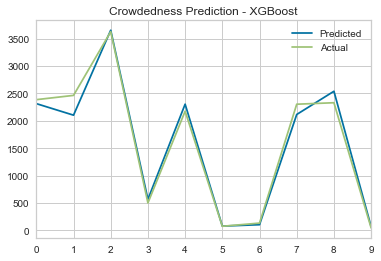

In [195]:
time_pred_series_reg_xgb.plot(legend=True, title='Crowdedness Prediction - XGBoost', label="Predicted")
time_real_series_reg_xgb.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [201]:
xgb_score = xgb_reg.score(x_eval_reg, y_eval_reg)

#Training
y_pred_xgb = xgb_reg.predict(x_eval_reg)
xgb_mse = mean_squared_error(y_pred_xgb, y_eval_reg)

print("R^2 Score: ", xgb_score)
print("MSE Test: ", xgb_mse)
print("RMSE Test: ", np.sqrt(xgb_mse))

R^2 Score:  0.5361123190873034
MSE Test:  383537.2865562742
RMSE Test:  619.3038725506843


D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


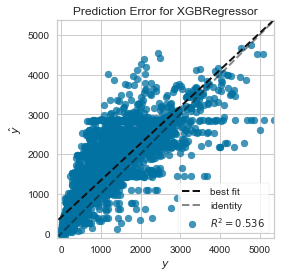

In [202]:
visualizer = PredictionError(xgb_reg)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_eval_reg, y_eval_reg)  # Evaluate the model on the test data
g = visualizer.poof()

In [203]:
#Time series
time_pred_xgb = xgb_reg.predict(x_series_reg)

time_pred_series_xgb = pd.Series(time_pred_xgb)
time_real_series_xgb = pd.Series(y_series_reg)

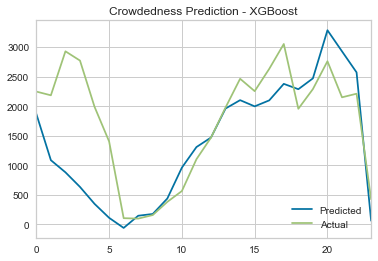

In [204]:
time_pred_series_xgb.plot(legend=True, title='Crowdedness Prediction - XGBoost', label="Predicted")
time_real_series_xgb.plot(legend=True, label="Actual")
plt.show()

### Lasso <a name="regABRModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV)

#### Training

In [226]:
lasso = LassoCV(n_jobs=50, random_state=42, n_alphas=5, normalize=True, precompute="auto", selection="random")

In [227]:
lasso.fit(x_train_reg, y_train_reg)

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=5, n_jobs=50, normalize=True, positive=False,
    precompute='auto', random_state=42, selection='random', tol=0.0001,
    verbose=False)

#### Test

In [228]:
reg_lasso_score=lasso.score(x_test_reg, y_test_reg)

y_pred_reg_lasso = lasso.predict(x_test_reg)
reg_lasso_mse = mean_squared_error(y_pred_reg_lasso, y_test_reg)

print("R^2 Sore: ", reg_lasso_score)
print("MSE: ", reg_lasso_mse)
print("RMSE: ", np.sqrt(reg_lasso_mse))

R^2 Sore:  0.6185011304864461
MSE:  669091.4092033622
RMSE:  817.9800787325827


In [229]:
for i in range(10):
    print("Predicted: ", y_pred_reg_lasso[i], "Real: ", y_test_reg[i])

Predicted:  2144.7402252126867 Real:  3813
Predicted:  490.0582744264711 Real:  105
Predicted:  3377.842090964158 Real:  3669
Predicted:  -85.4098814781629 Real:  80
Predicted:  3383.849328791046 Real:  3470
Predicted:  2189.4977707946855 Real:  515
Predicted:  2593.7499899507047 Real:  2315
Predicted:  2189.4977707946855 Real:  340
Predicted:  2245.3972292637573 Real:  3406
Predicted:  1841.1225634816974 Real:  348


D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


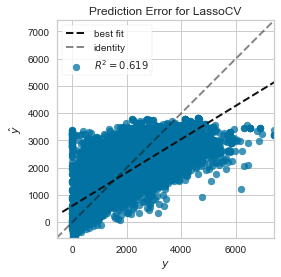

In [230]:
visualizer = PredictionError(lasso)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_test_reg, y_test_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

In [231]:
#Time series
time_pred_reg_lasso = lasso.predict(x_test_reg_series)

time_pred_series_reg_lasso = pd.Series(time_pred_reg_lasso)
time_real_series_reg_lasso = pd.Series(y_test_reg_series)

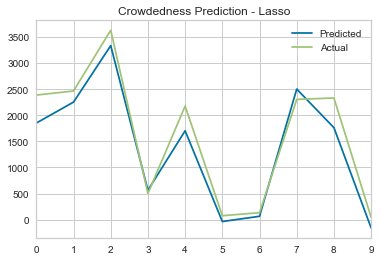

In [232]:
time_pred_series_reg_lasso.plot(legend=True, title='Crowdedness Prediction - Lasso', label="Predicted")
time_real_series_reg_lasso.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [233]:
lasso_score=lasso.score(x_eval_reg, y_eval_reg)

y_pred_lasso = lasso.predict(x_eval_reg)
lasso_mse = mean_squared_error(y_pred_lasso, y_eval_reg)

print("R^2 Sore: ", lasso_score)
print("MSE: ", lasso_mse)
print("RMSE: ", np.sqrt(lasso_mse))

R^2 Sore:  0.30178192485949595
MSE:  577279.1065221931
RMSE:  759.7888565398897


D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


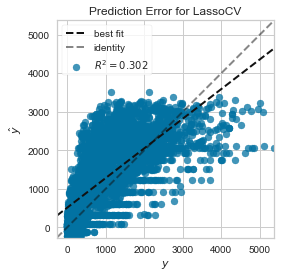

In [234]:
visualizer = PredictionError(lasso)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_eval_reg, y_eval_reg)  # Evaluate the model on the test data
g = visualizer.poof()

In [235]:
#Time series
time_pred_lasso = lasso.predict(x_series_reg)

time_pred_series_lasso = pd.Series(time_pred_lasso)
time_real_series_lasso = pd.Series(y_series_reg)

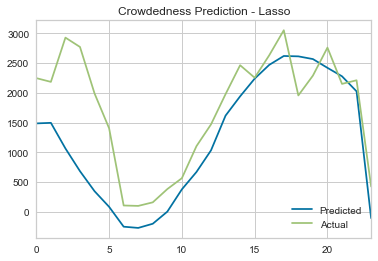

In [236]:
time_pred_series_lasso.plot(legend=True, title='Crowdedness Prediction - Lasso', label="Predicted")
time_real_series_lasso.plot(legend=True, label="Actual")
plt.show()

## Classification Models <a name="classification"></a>

### Change numerical labels to categorical labels <a name="classCatVar"></a>

In [203]:
low_split = TrainTest_df["CrowdednessCount"].quantile(.25)
mid_split = TrainTest_df["CrowdednessCount"].quantile(.5)
high_split = TrainTest_df["CrowdednessCount"].quantile(.75)

In [241]:
clas_dict = TrainTest_df.to_dict("index")

for k, v in clas_dict.items():
    
    if v["CrowdednessCount"] < low_split:
        v["CrowdednessCount"] = 1
    elif v["CrowdednessCount"] >= low_split and v["CrowdednessCount"] < mid_split:
        v["CrowdednessCount"] = 2
    elif v["CrowdednessCount"] >= mid_split and v["CrowdednessCount"] < high_split:
        v["CrowdednessCount"] = 3
    elif v["CrowdednessCount"] >= high_split:
        v["CrowdednessCount"] = 4
    else:
        print (k, " has class error as it fits in none")
    
clas_model_df = pd.DataFrame.from_dict(clas_dict, orient="index")

In [242]:
series_dict = TimeSeries_df.to_dict("index")

for k, v in series_dict.items():
    
    if v["CrowdednessCount"] < low_split:
        v["CrowdednessCount"] = 1
    elif v["CrowdednessCount"] >= low_split and v["CrowdednessCount"] < mid_split:
        v["CrowdednessCount"] = 2
    elif v["CrowdednessCount"] >= mid_split and v["CrowdednessCount"] < high_split:
        v["CrowdednessCount"] = 3
    elif v["CrowdednessCount"] >= high_split:
        v["CrowdednessCount"] = 4
    else:
        print (k, " has class error as it fits in none")
    
TimeSeries_df_clas = pd.DataFrame.from_dict(series_dict, orient="index")    

In [243]:
TimeSeries_df_clas.head()

,Date,Hour,is_event,event_lat,event_lon,NieuwmarktLat,NieuwmarktLon,NieuwmarktArrivals,NieuwmarktDepartures,NieuwezijdsLat,...,SensorLongitude,SensorLatitude,Year,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,CrowdednessCount
0,2019-01-01,2400,0.0,0.0,0.0,52.371942,4.901239,10.0,20.0,52.376288,...,4.898903,52.373786,2019,0.5,0.866025,0.017213,0.999852,-2.449294e-16,1.000000,3
1,2019-01-01,2400,0.0,0.0,0.0,52.371942,4.901239,10.0,20.0,52.376288,...,4.897334,52.372524,2019,0.5,0.866025,0.017213,0.999852,-2.449294e-16,1.000000,2
2,2019-01-01,100,0.0,0.0,0.0,52.371942,4.901239,25.0,531.0,52.376288,...,4.898903,52.373786,2019,0.5,0.866025,0.017213,0.999852,2.588190e-01,0.965926,3
3,2019-01-01,100,0.0,0.0,0.0,52.371942,4.901239,25.0,531.0,52.376288,...,4.897334,52.372524,2019,0.5,0.866025,0.017213,0.999852,2.588190e-01,0.965926,2
4,2019-01-01,200,0.0,0.0,0.0,52.371942,4.901239,68.0,329.0,52.376288,...,4.897334,52.372524,2019,0.5,0.866025,0.017213,0.999852,5.000000e-01,0.866025,2


In [244]:
train_df_clas = clas_model_df[clas_model_df["Date"].isin(train_set_dates)].reset_index().drop(columns=["Date", "Hour",
                                                                                                       "index"])

test_df_clas = clas_model_df[clas_model_df["Date"].isin(test_set_dates)].reset_index()

In [245]:
#Train
x_train_clas = train_df_clas.drop(["CrowdednessCount"], axis=1)
y_train_clas = train_df_clas["CrowdednessCount"]

#Test
x_test_clas = test_df_clas.drop(["CrowdednessCount", "Date", "index", "Hour"], axis=1)
y_test_clas = test_df_clas["CrowdednessCount"]

test_clas_series = test_df_clas[(test_df_clas["Date"] == test_set_dates[2]) & (test_df_reg["SensorLongitude"] == 4.8989027)
                             ].reset_index()
x_test_clas_series = test_clas_series.drop(["CrowdednessCount", "Date", "Hour", "index", "level_0"], axis=1)
y_test_clas_series = test_clas_series["CrowdednessCount"]

#Time series
seriesDate_clas = TimeSeries_df_clas["Date"].values

x_eval_clas = TimeSeries_df_clas.drop(["CrowdednessCount", "Date", "Hour"], axis=1)
y_eval_clas = TimeSeries_df_clas["CrowdednessCount"]

sub_series_clas = TimeSeries_df_clas[(TimeSeries_df["SensorLongitude"] == 4.8989027) & (TimeSeries_df["Date"] 
                                                                                   == seriesDate_clas[1])].reset_index()

x_series_clas = sub_series_clas.drop(["CrowdednessCount", "Date", "Hour", "index"], axis=1)
y_series_clas = sub_series_clas["CrowdednessCount"]

### Baseline <a name="classBaseModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier)

Parameters
- *strategy*: "stratified” - generates predictions by respecting the training set’s class distribution.

#### Training

In [246]:
clas_bas = DummyClassifier(strategy="most_frequent", random_state=42)

In [247]:
clas_bas.fit(x_train_clas, y_train_clas)

DummyClassifier(constant=None, random_state=42, strategy='most_frequent')

#### Test

In [248]:
y_pred_clas_bas = clas_bas.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_clas_bas))
print(classification_report(y_test_clas, y_pred_clas_bas))

Accuracy Score:  0.24958546608031143
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      3475
           2       0.00      0.00      0.00      3460
           3       0.00      0.00      0.00      3474
           4       0.25      1.00      0.40      3462

   micro avg       0.25      0.25      0.25     13871
   macro avg       0.06      0.25      0.10     13871
weighted avg       0.06      0.25      0.10     13871



D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


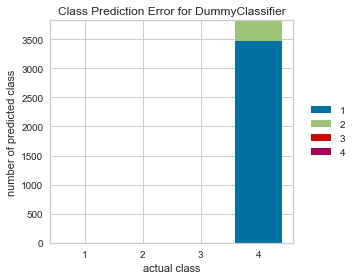

In [249]:
visualizer = ClassPredictionError(
    clas_bas
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

In [250]:
#Time series
time_pred_bas_clas = clas_bas.predict(x_test_clas_series)

time_pred_series_bas_clas = pd.Series(time_pred_bas_clas)
time_real_series_bas_clas = pd.Series(y_test_clas_series)

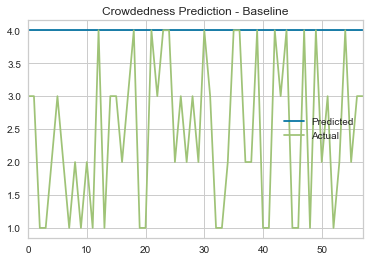

In [251]:
time_pred_series_bas_clas.plot(legend=True, title='Crowdedness Prediction - Baseline', label="Predicted")
time_real_series_bas_clas.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [252]:
y_pred_bas = clas_bas.predict(x_eval_clas)

print("Accuracy Score: ", accuracy_score(y_eval_clas, y_pred_bas))
print(classification_report(y_eval_clas, y_pred_bas))

Accuracy Score:  0.07314814814814814
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1429
           2       0.00      0.00      0.00      1716
           3       0.00      0.00      0.00       859
           4       0.07      1.00      0.14       316

   micro avg       0.07      0.07      0.07      4320
   macro avg       0.02      0.25      0.03      4320
weighted avg       0.01      0.07      0.01      4320



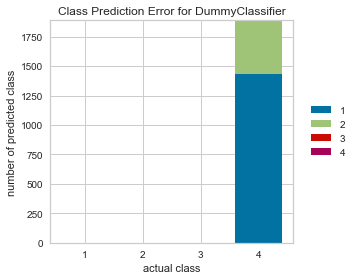

In [253]:
visualizer = ClassPredictionError(
    clas_bas
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_eval_clas, y_eval_clas)
g = visualizer.poof()

In [254]:
#Time series
time_pred_bas = clas_bas.predict(x_series_clas)

time_pred_series_bas = pd.Series(time_pred_bas)
time_real_series_bas = pd.Series(y_series_clas)

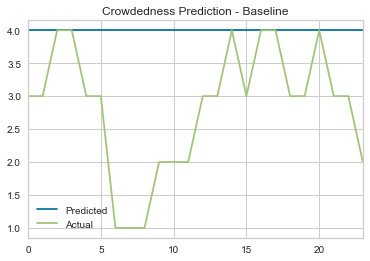

In [255]:
time_pred_series_bas.plot(legend=True, title='Crowdedness Prediction - Baseline', label="Predicted")
time_real_series_bas.plot(legend=True, label="Actual")
plt.show()

### Random Forrest Classifier <a name="classRFCModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

#### Train

In [256]:
clas_rfc = RandomForestClassifier(n_estimators=300, criterion="entropy", n_jobs=20, random_state=42, 
                                  class_weight="balanced")

In [257]:
clas_rfc.fit(x_train_clas, y_train_clas)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=20, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

#### Test

In [258]:
y_pred_clas_rfc = clas_rfc.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_clas_rfc))
print(classification_report(y_test_clas, y_pred_clas_rfc))

Accuracy Score:  0.9881767716819263
              precision    recall  f1-score   support

           1       0.99      0.99      0.99      3475
           2       0.99      0.99      0.99      3460
           3       0.99      0.98      0.98      3474
           4       0.99      0.99      0.99      3462

   micro avg       0.99      0.99      0.99     13871
   macro avg       0.99      0.99      0.99     13871
weighted avg       0.99      0.99      0.99     13871



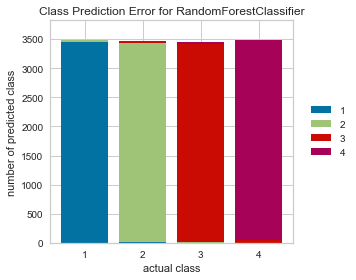

In [259]:
visualizer = ClassPredictionError(
    clas_rfc
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

In [260]:
#Time series
time_pred_rfc_clas = clas_rfc.predict(x_test_clas_series)

time_pred_series_rfc_clas = pd.Series(time_pred_rfc_clas)
time_real_series_rfc_clas = pd.Series(y_test_clas_series)

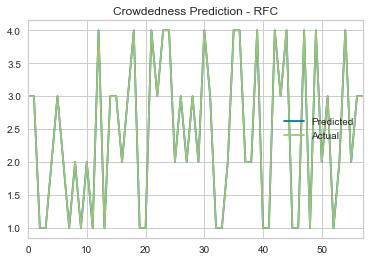

In [261]:
time_pred_series_rfc_clas.plot(legend=True, title='Crowdedness Prediction - RFC', label="Predicted")
time_real_series_rfc_clas.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [262]:
y_pred_rfc = clas_rfc.predict(x_eval_clas)

print("Accuracy Score: ", accuracy_score(y_eval_clas, y_pred_rfc))
print(classification_report(y_eval_clas, y_pred_rfc))

Accuracy Score:  0.5518518518518518
              precision    recall  f1-score   support

           1       0.54      0.87      0.67      1429
           2       0.74      0.37      0.49      1716
           3       0.41      0.38      0.40       859
           4       0.47      0.58      0.52       316

   micro avg       0.55      0.55      0.55      4320
   macro avg       0.54      0.55      0.52      4320
weighted avg       0.59      0.55      0.53      4320



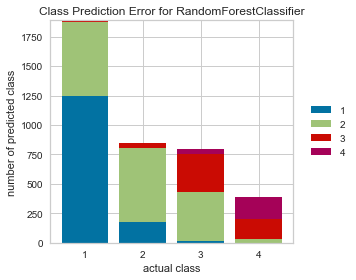

In [263]:
visualizer = ClassPredictionError(
    clas_rfc
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_eval_clas, y_eval_clas)
g = visualizer.poof()

In [264]:
#Time series
time_pred_rfc = clas_rfc.predict(x_series_clas)

time_pred_series_rfc = pd.Series(time_pred_rfc)
time_real_series_rfc = pd.Series(y_series_clas)

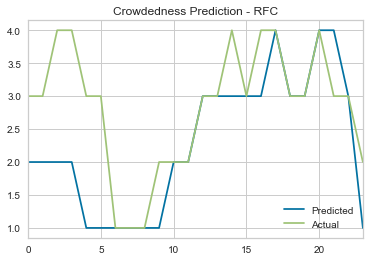

In [265]:
time_pred_series_rfc.plot(legend=True, title='Crowdedness Prediction - RFC', label="Predicted")
time_real_series_rfc.plot(legend=True, label="Actual")
plt.show()

### XGBoost 
Implement [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html) (should outperform the above given model)

#### Training

In [339]:
xgb_clas = xgb.XGBClassifier(random_state=42, n_estimators=300, max_depth=8, 
                              learning_rate=0.2, booster="gbtree", n_jobs=20)

In [340]:
xgb_clas.fit(x_train_clas, y_train_clas)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=20, nthread=None, objective='multi:softprob',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

#### Test

In [341]:
y_pred_clas_xgb = xgb_clas.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_clas_xgb))
print(classification_report(y_test_clas, y_pred_clas_xgb))

Accuracy Score:  0.9880325859707303
              precision    recall  f1-score   support

           1       0.99      0.99      0.99      3475
           2       0.98      0.99      0.99      3460
           3       0.99      0.98      0.98      3474
           4       0.99      0.99      0.99      3462

   micro avg       0.99      0.99      0.99     13871
   macro avg       0.99      0.99      0.99     13871
weighted avg       0.99      0.99      0.99     13871



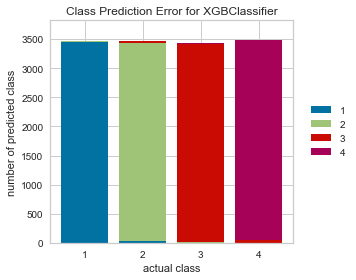

In [342]:
visualizer = ClassPredictionError(
    xgb_clas, 
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

In [343]:
#Time series
time_pred_clas_xgb = xgb_clas.predict(x_test_clas_series)

time_pred_series_clas_xgb = pd.Series(time_pred_clas_xgb)
time_real_series_clas_xgb = pd.Series(y_test_clas_series)

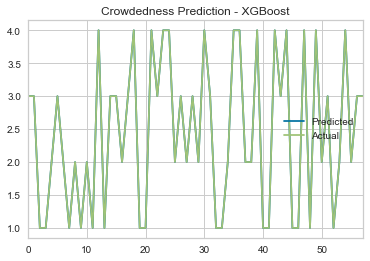

In [344]:
time_pred_series_clas_xgb.plot(legend=True, title='Crowdedness Prediction - XGBoost', label="Predicted")
time_real_series_clas_xgb.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [345]:
y_pred_xgb = xgb_clas.predict(x_series_clas)

print("Accuracy Score: ", accuracy_score(y_series_clas, y_pred_xgb))
print(classification_report(y_series_clas, y_pred_xgb))

Accuracy Score:  0.5416666666666666
              precision    recall  f1-score   support

           1       0.50      1.00      0.67         3
           2       0.43      0.75      0.55         4
           3       0.80      0.36      0.50        11
           4       0.50      0.50      0.50         6

   micro avg       0.54      0.54      0.54        24
   macro avg       0.56      0.65      0.55        24
weighted avg       0.63      0.54      0.53        24



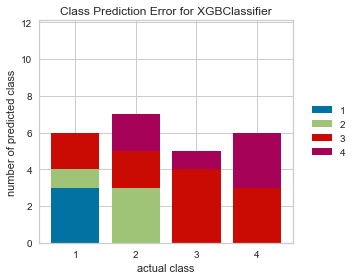

In [346]:
visualizer = ClassPredictionError(
    xgb_clas, 
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_series_clas, y_series_clas)
g = visualizer.poof()

In [347]:
#Time series
time_pred_xgb = xgb_clas.predict(x_series_clas)

time_pred_series_xgb = pd.Series(time_pred_xgb)
time_real_series_xgb = pd.Series(y_series_clas)

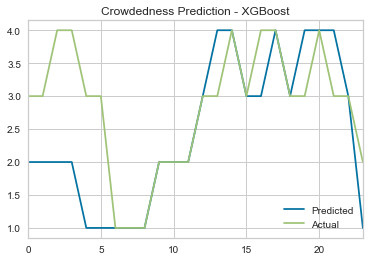

In [348]:
time_pred_series_xgb.plot(legend=True, title='Crowdedness Prediction - XGBoost', label="Predicted")
time_real_series_xgb.plot(legend=True, label="Actual")
plt.show()

### SVC 
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

#### Training

In [163]:
clas_svc = SVC(kernel="rbf", random_state=42, class_weight="balanced")

In [164]:
clas_svc.fit(x_train_clas, y_train_clas)

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

#### Test

In [165]:
y_pred_clas_svc = clas_svc.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_clas_svc))
print(classification_report(y_test_clas, y_pred_clas_svc))

Accuracy Score:  0.8260399394420013
              precision    recall  f1-score   support

           1       0.96      0.87      0.91      3475
           2       0.80      0.74      0.77      3460
           3       0.67      0.96      0.79      3474
           4       0.99      0.74      0.85      3462

   micro avg       0.83      0.83      0.83     13871
   macro avg       0.86      0.83      0.83     13871
weighted avg       0.86      0.83      0.83     13871



D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


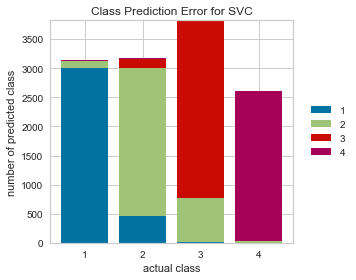

In [166]:
visualizer = ClassPredictionError(
    clas_svc
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

In [172]:
#Time series
time_pred_clas_svc = clas_svc.predict(x_test_clas_series)

time_pred_series_clas_svc = pd.Series(time_pred_clas_svc)
time_real_series_clas_svc = pd.Series(y_test_clas_series)

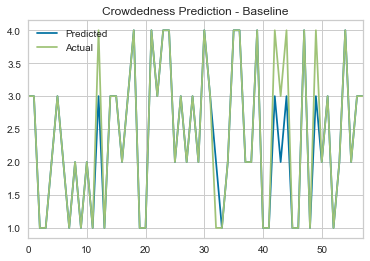

In [173]:
time_pred_series_clas_svc.plot(legend=True, title='Crowdedness Prediction - Baseline', label="Predicted")
time_real_series_clas_svc.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [170]:
y_pred_svc = clas_svc.predict(x_series_clas)

print("Accuracy Score: ", accuracy_score(y_series_clas, y_pred_svc))
print(classification_report(y_series_clas, y_pred_svc))

Accuracy Score:  0.4583333333333333
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         4
           3       0.46      1.00      0.63        11
           4       0.00      0.00      0.00         6

   micro avg       0.46      0.46      0.46        24
   macro avg       0.11      0.25      0.16        24
weighted avg       0.21      0.46      0.29        24



D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


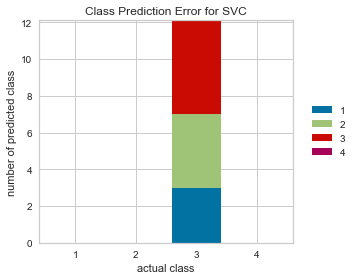

In [171]:
visualizer = ClassPredictionError(
    clas_svc
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_series_clas, y_series_clas)
g = visualizer.poof()

In [176]:
#Time series
time_pred_svc = clas_svc.predict(x_series_clas)

time_pred_series_svc = pd.Series(time_pred_svc)
time_real_series_svc = pd.Series(y_series_clas)

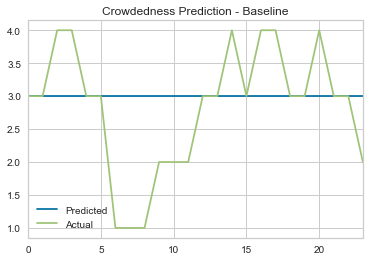

In [177]:
time_pred_series_svc.plot(legend=True, title='Crowdedness Prediction - Baseline', label="Predicted")
time_real_series_svc.plot(legend=True, label="Actual")
plt.show()

### Voting Classifier <a name="classVCModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier)

This classifier combines the classifications of the [Random Forrest Classification](#classRFCModel) and [Gradient Boosting Classification](#classGBCModel) by classifying each instance with the one of the classes given by the models. 

#### Training

In [178]:
#List estimator models
estimators = [("rfc", clas_rfc), ("gbc", clas_gbc)]

clas_vc = VotingClassifier(estimators=estimators, voting="soft", n_jobs=20,weights=[1, 1])

In [179]:
clas_vc.fit(x_train_clas, y_train_clas)

VotingClassifier(estimators=[('rfc', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=20, voting='soft', weights=[1, 1])

#### Test

In [180]:
y_pred_vc = clas_vc.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_vc))
print(classification_report(y_test_clas, y_pred_vc))

Accuracy Score:  0.9581140508975561
              precision    recall  f1-score   support

           1       0.99      0.97      0.98      3475
           2       0.94      0.94      0.94      3460
           3       0.95      0.94      0.95      3474
           4       0.95      0.98      0.97      3462

   micro avg       0.96      0.96      0.96     13871
   macro avg       0.96      0.96      0.96     13871
weighted avg       0.96      0.96      0.96     13871



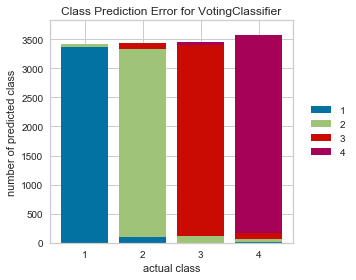

In [181]:
visualizer = ClassPredictionError(
    clas_vc
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

In [182]:
#Time series
time_pred_clas_vc = clas_vc.predict(x_test_clas_series)

time_pred_series_clas_vc = pd.Series(time_pred_clas_vc)
time_real_series_clas_vc = pd.Series(y_test_clas_series)

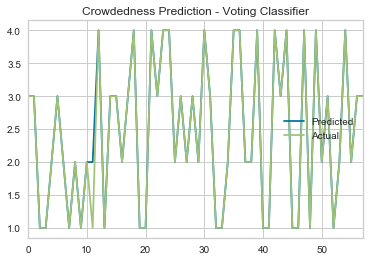

In [183]:
time_pred_series_clas_vc.plot(legend=True, title='Crowdedness Prediction - Voting Classifier', label="Predicted")
time_real_series_clas_vc.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [184]:
y_pred_vc = clas_vc.predict(x_series_clas)

print("Accuracy Score: ", accuracy_score(y_series_clas, y_pred_vc))
print(classification_report(y_series_clas, y_pred_vc))

Accuracy Score:  0.5
              precision    recall  f1-score   support

           1       0.50      1.00      0.67         3
           2       0.43      0.75      0.55         4
           3       0.67      0.36      0.47        11
           4       0.40      0.33      0.36         6

   micro avg       0.50      0.50      0.50        24
   macro avg       0.50      0.61      0.51        24
weighted avg       0.54      0.50      0.48        24



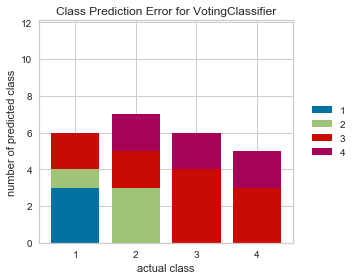

In [185]:
visualizer = ClassPredictionError(
    clas_vc
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_series_clas, y_series_clas)
g = visualizer.poof()

In [186]:
#Time series
time_pred_vc = clas_vc.predict(x_series_clas)

time_pred_series_vc = pd.Series(time_pred_vc)
time_real_series_vc = pd.Series(y_series_clas)

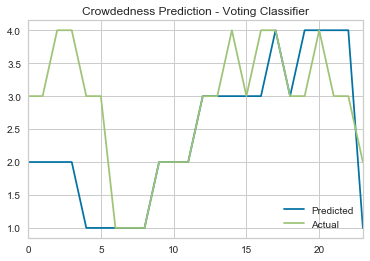

In [187]:
time_pred_series_vc.plot(legend=True, title='Crowdedness Prediction - Voting Classifier', label="Predicted")
time_real_series_vc.plot(legend=True, label="Actual")
plt.show()